In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from DEDi import ode_find as ode
from DEDi.ODE.PolyLib import PolyFunc
import numpy as np
import matplotlib.pyplot as plt

### Lorenz Oscillator

$(\sigma,\rho,\beta) = (10,28,8/3)$

\begin{align}
    \frac{dx}{dt} &= \sigma(y-x) \\
    \frac{dy}{dt} &= x(\rho - z) - y \\ 
    \frac{dz}{dt} &= xy - \beta z\\ 

\end{align}

Dropped 30.0% of Data
Size = (250, 3), dt = 0.04


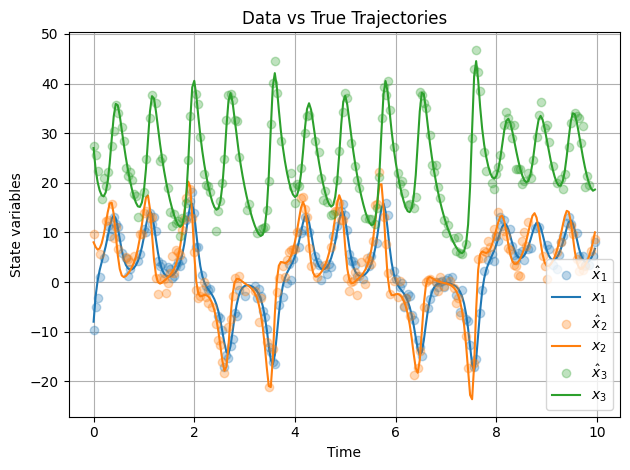

In [2]:
Data = np.load('../_ODEData/LorenzData.npz')
x_data_true_full = Data['x']
t_full = Data['t']

np.random.seed(123)
subsample = 40
x_data_true = x_data_true_full[::subsample]
t = t_full[::subsample]


noise_p, stand_dev = .2, np.std(x_data_true, axis = 0)
x_data = x_data_true + np.random.normal(0,stand_dev*noise_p, size = x_data_true.shape)

#Define a state mask
state_mask = np.ones_like(x_data, dtype=bool)
drop_percent = 0.3
num_to_drop = int(drop_percent * state_mask.size)
drop_indices = np.random.choice(state_mask.size, size=num_to_drop, replace=False)
state_mask.flat[drop_indices] = False
print(f"Dropped {100*np.sum(~state_mask)/np.size(state_mask):.1f}% of Data") #Verify it dropped the right amount
x_data = x_data*state_mask #Make sure to remove before putting it into optimization, simulates missing data

# Define validation mask, standard is every third time (33% of data)
validation_mask = np.ones_like(x_data, dtype=bool)
validation_mask[2::3] = False

print(f'Size = {np.shape(x_data)}, dt = {t[1]-t[0]}')
from DEDi.plot_trajectories  import plot_trajectory
x_data_for_plotting = x_data.copy()
x_data_for_plotting[np.where(x_data_for_plotting == 0)] = np.nan #Otherwise it will show up as zeros, which is wrong
plot_trajectory(t,x_data_for_plotting,x_data_true)

In [3]:
Library = PolyFunc(num_vars=x_data.shape[1],degree=2)
print(Library)

# Initialize Library & Model Discovery
# lambdas,Rs  = 10**(np.linspace(-3, 3, 7)),10**(np.linspace(-4, 0, 5))  #Parameter's used in paper, better to try a simple run first 
lambdas = [10**(-2)]
Rs = [10**(-4)]

discoverode = ode(x_data,Library,[t[0],t[-1]],state_mask=state_mask, validation_mask=validation_mask)
discoverode.FindBestModel(lambdas, Rs)

['x_1', 'x_2', 'x_3', 'x_1**2', 'x_1*x_2', 'x_1*x_3', 'x_2**2', 'x_2*x_3', 'x_3**2']
Setting up Sparse Hessian
Colors Needed = 38
[INFO] Validation mask includes entries with missing data. These will be ignored during validation error computation.
[Failed to Converged] Iter 500: ||grad|| = 2.44e+01
[Failed to Converged] Iter 500: ||grad|| = 4.08e+01
lam = 1.00e-02, R = 1.00e-04, nonzero = 7, val_error = 2.6439e+00,BIC = 2.08e+02, model_error = 3.3453e-05, state_error = 2.4789e+00


In [4]:
models = discoverode.PrintModels(N_best= 5) #Increase cutoff to see other models found

<IPython.core.display.Latex object>

L2 Error = 5.820e-02, LInf Error = 1.432e-01, TPR = 100%


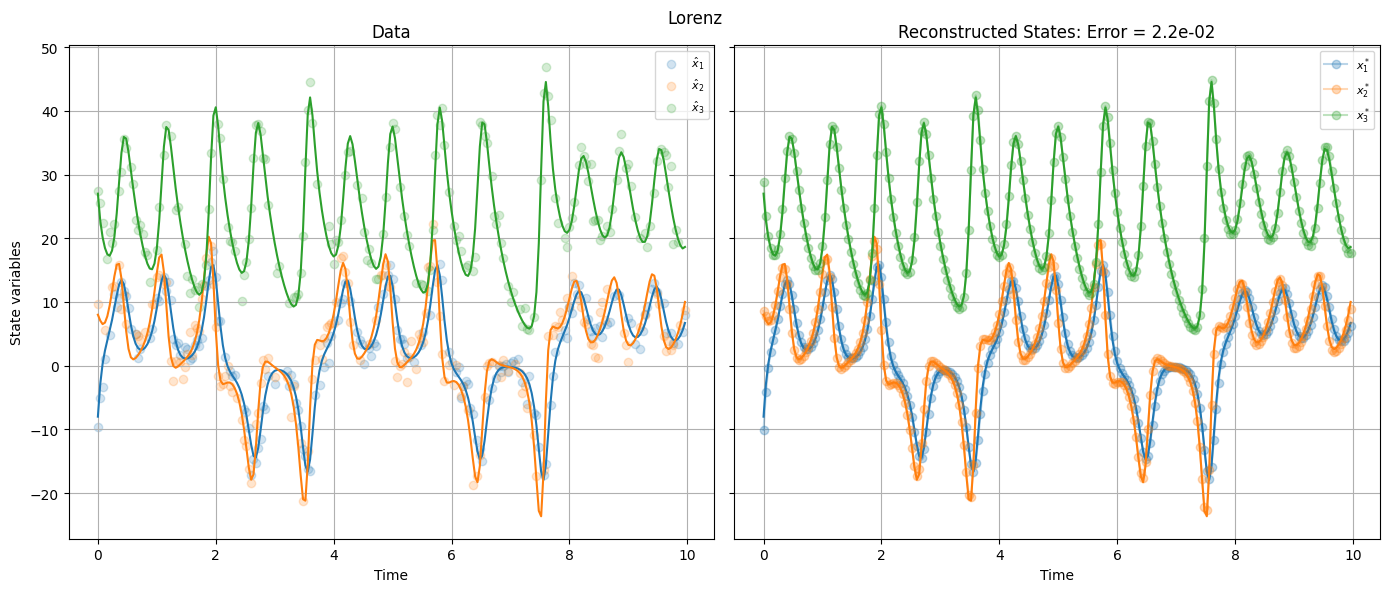

In [5]:
opt_params, opt_NL_params, opt_states = discoverode.best_model()

from _ODEData.Functions.ODEFuncs import generate_coeff_matrix, getlorenzcoeffs, Report_Errors
true_coeffs = generate_coeff_matrix(Library, getlorenzcoeffs())
L2_error, LInf_error, true_positivity_ratio = Report_Errors(true_coeffs, opt_params)
print(f"L2 Error = {L2_error:.3e}, LInf Error = {LInf_error:.3e}, TPR = {int(true_positivity_ratio*100)}%")

from DEDi.plot_trajectories  import plot_solution
plot_solution(t,x_data_for_plotting,opt_states,x_data_true, title= f"Lorenz")
# plt.savefig('Images/Lorenz_randomly_missing.pdf')